In [1]:
import rebound
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
from scipy.interpolate import interp1d
import pymc3 as pm
import scipy
from scipy.integrate import quad

plt.style.use('paper.mplstyle')
%matplotlib inline

In [2]:
dfttvs = pd.read_csv("Kepler-23_TTVs.csv", index_col=0)
dfttvs.tail()

,mu1,per1,h1,k1,Tc1,mu2,per2,h2,k2,Tc2,...,mean_long2,pomega3,e3,mean_long3,ecom,Mstar,Z12,Zcom12,Z23,Zcom23
249995,0.000003,7.105870,-0.038511,-0.196506,57.031001,0.000006,10.743525,0.032910,-0.196457,55.659821,...,5.147323,-1.075444,0.199238,4.333169,0.195363,1.078,0.057631,0.225597,0.052884,0.202704
249996,0.000003,7.106110,-0.069445,0.025974,56.975209,0.000006,10.743671,0.000208,-0.003399,55.525812,...,5.226137,-0.406624,0.062597,4.431526,0.002368,1.078,0.048022,0.029157,0.047269,0.025118
249997,0.000004,7.106614,-0.001841,-0.075112,57.111239,0.000004,10.743291,0.044821,-0.081911,55.689775,...,5.129095,-0.580675,0.077984,4.414196,0.075583,1.078,0.039443,0.087032,0.029061,0.090067
249998,0.000003,7.106508,-0.087985,0.084049,56.927508,0.000004,10.743239,-0.016223,0.039809,55.475669,...,5.254157,0.894684,0.026970,4.517402,0.044281,1.078,0.048540,0.084217,0.025173,0.031784
249999,0.000004,7.106154,-0.122730,-0.000055,56.853333,0.000009,10.743234,-0.046245,-0.023290,55.364239,...,5.319310,-2.470655,0.004345,4.557613,0.066148,1.078,0.045531,0.083131,0.029906,0.047402


In [3]:
dfstab = pd.read_csv('Kepler-23_stability.csv', index_col=0)
dfstab.tail()

,sim,Mstar,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,h1,...,mu1,mu2,mu3,mu1+mu2,mu2+mu3,mutot,ecom,t_instability,nbodystable,spockprob
27048,1999380.0,0.880613,0.201449,0.139535,0.102941,0.132488,0.198727,0.155031,0.014555,-0.099066,...,2.729311e-06,0.000012,0.000003,0.000015,0.000015,0.000018,0.101288,5.358731e+04,0.0,0.010296
27049,1999466.0,1.214257,0.028842,0.012843,0.021864,0.008439,0.039781,0.010983,0.022669,-0.039776,...,8.367568e-07,0.000042,0.000007,0.000043,0.000049,0.000050,0.008076,1.000000e+09,1.0,0.787886
27050,1999693.0,1.225737,0.075410,0.120734,0.066761,0.111895,0.088874,0.108052,0.175515,0.080759,...,9.338099e-06,0.000078,0.000004,0.000087,0.000081,0.000091,0.104393,6.319852e+04,0.0,0.009134
27051,1999943.0,1.083352,0.130139,0.262373,0.077109,0.180838,0.224166,0.236365,0.140135,0.222827,...,1.474248e-06,0.000006,0.000018,0.000007,0.000024,0.000025,0.156694,2.133985e+04,0.0,0.005355
27052,1999969.0,1.159434,0.046016,0.032291,0.051997,0.031372,0.095140,0.020418,0.050637,-0.057283,...,3.549245e-06,0.000037,0.000085,0.000040,0.000122,0.000125,0.026185,5.152893e+05,0.0,0.014513


In [4]:
dftd = pd.read_csv('Kepler-23_transitdurations.csv', index_col=0)
dftd.tail()

,ID,Mstar,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,mu1,...,mu1+mu2,mu2+mu3,mutot,h1,h2,h3,k1,k2,k3,ecom
39995,39995.0,1.078,0.255002,0.219570,0.241360,0.209458,0.127092,0.284903,0.147279,0.000017,...,0.000058,0.000057,0.000074,0.042600,-0.283499,0.053627,0.119740,0.028253,0.137169,0.151633
39996,39996.0,1.078,0.167373,0.060257,0.100118,0.029407,0.262542,0.001692,0.130529,0.000008,...,0.000044,0.000046,0.000054,0.076042,0.001623,0.034801,-0.251288,0.000479,0.125804,0.023035
39997,39997.0,1.078,0.312808,0.203716,0.270535,0.179107,0.392362,0.198785,0.305235,0.000019,...,0.000056,0.000060,0.000079,-0.091950,-0.185938,-0.106741,-0.381435,0.070304,-0.285963,0.199702
39998,39998.0,1.078,0.427064,0.347577,0.235449,0.420195,0.124926,0.495464,0.299385,0.000012,...,0.000033,0.000038,0.000050,0.101222,-0.392509,-0.034320,0.073216,0.302360,0.297411,0.289026
39999,39999.0,1.078,0.622926,0.460633,0.089570,0.727851,0.023163,0.722732,0.518803,0.000013,...,0.000029,0.000028,0.000040,-0.001221,-0.302022,-0.204131,-0.023130,0.656600,0.476957,0.430164


In [5]:
def calcHPDI(vals, interval, guess, weights=None):
    '''
    Fit a gaussian KDE, find max likelihood, and calculate 
    minimum interval that holds `interval` percentage of the distribution.
    This is what Hadden 2017 quote

        vals : array of values
        interval: float for size of interval
        guess: initial guess for max likelihood
    '''
    vals = np.concatenate([vals, vals*(-1)]) # reflect values to negative to avoid edge effects at zero
    try:
        weights=np.concatenate([weights, weights])
    except:
        pass
    
    kde = scipy.stats.gaussian_kde(vals, bw_method=1/15, weights=weights)
    maxlike = scipy.optimize.fmin(lambda x: -kde(x), x0=guess, disp=False)[0]
    
    sample = kde.resample(10000) # need to do this step in case we need to weight the vals by weights (for SPOCK probs)
    samplecut = sample[sample > 0]

    low, high = pm.stats.hpd(samplecut, credible_interval=interval)
    return kde, maxlike, high, low

In [6]:
def plot(ax, col, xlabel, labels=False):
    Nbins=50
    
    if labels:
        ax.hist(dfstab[col][:10000], color='gray', alpha=0.5, density=True, label="Prior", bins=Nbins)
    else:
        ax.hist(dfstab[col][:10000], color='gray', alpha=0.5, density=True, bins=Nbins)

    label = "Transit Durations\n" if labels else ""
    kde, maxlike, high, low = calcHPDI(dftd[col], interval=0.683, guess=0.1)
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    ax.hist(dftd[col], alpha=0.5, density=True, label=label, bins=Nbins, range=[0,1])
    
    label = "Stability\n" if labels else ""
    kde, maxlike, high, low = calcHPDI(dfstab[stable][col], interval=0.683, guess=0.1)
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    vals, bins, _ = ax.hist(dfstab[stable][col], alpha=0.5, density=True, label=label, bins=Nbins, range=[0,0.5])
    
    label = "Transit Time Variations\n" if labels else ""
    kde, maxlike, high, low = calcHPDI(dfttvs[col], interval=0.683, guess=0.1)
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    
    ax.hist(dfttvs[col], alpha=0.5, density=True, bins=bins, label=label)
    
    ax.set_xlabel(xlabel)

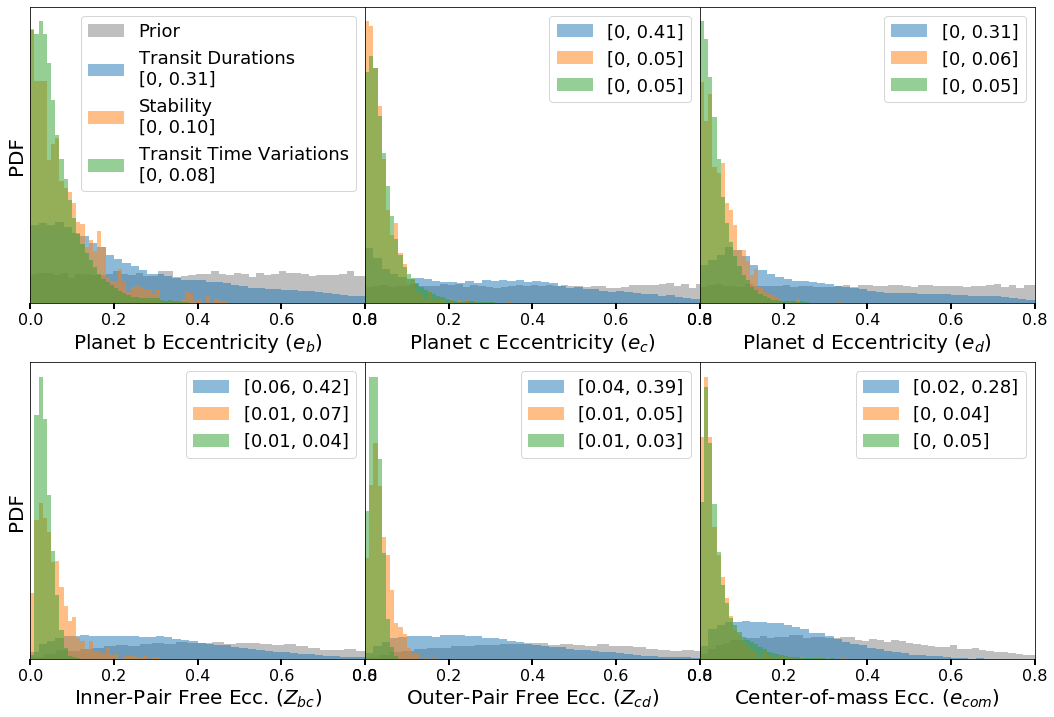

In [18]:
Nbins=50
stable = (dfstab['nbodystable'] == 1)# & (dfstab['e3']<0.8)
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(18,12))
plt.subplots_adjust(wspace=0)

plot(axarr[0,0], 'e1', 'Planet b Eccentricity ($e_b$)', labels=True)
plot(axarr[0,1], 'e2', 'Planet c Eccentricity ($e_c$)')
plot(axarr[0,2], 'e3', 'Planet d Eccentricity ($e_d$)')
plot(axarr[1,0], 'Z12', 'Inner-Pair Free Ecc. ($Z_{bc}$)')
plot(axarr[1,1], 'Z23', 'Outer-Pair Free Ecc. ($Z_{cd}$)')
plot(axarr[1,2], 'ecom', 'Center-of-mass Ecc. ($e_{com}$)')

for ax in axarr.flatten():
    ax.set_xlim([0,0.8])
    ax.axes.yaxis.set_ticks([])
    ax.legend(fontsize=18)

axarr[0,0].set_ylabel('PDF')
axarr[1,0].set_ylabel('PDF')
fig.savefig('eccentricitycomparison.pdf', bbox_inches='tight')

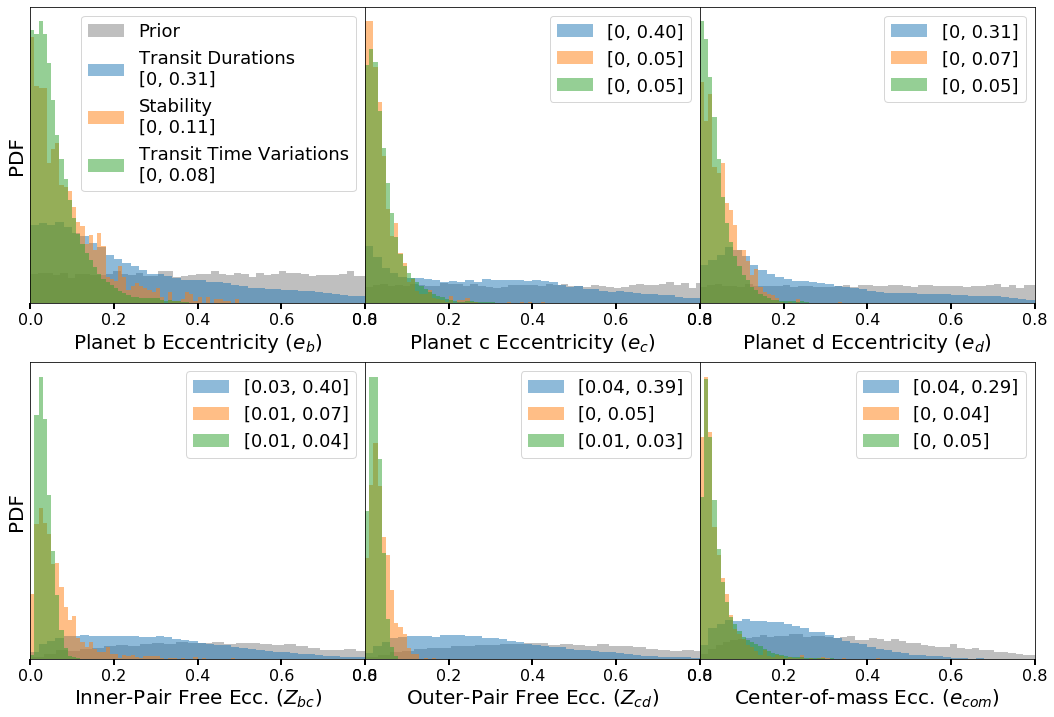

In [19]:
Nbins=50
stable = (dfstab['nbodystable'] == 1)# & (dfstab['e3']<0.8)
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(18,12))
plt.subplots_adjust(wspace=0)

plot(axarr[0,0], 'e1', 'Planet b Eccentricity ($e_b$)', labels=True)
plot(axarr[0,1], 'e2', 'Planet c Eccentricity ($e_c$)')
plot(axarr[0,2], 'e3', 'Planet d Eccentricity ($e_d$)')
plot(axarr[1,0], 'Z12', 'Inner-Pair Free Ecc. ($Z_{bc}$)')
plot(axarr[1,1], 'Z23', 'Outer-Pair Free Ecc. ($Z_{cd}$)')
plot(axarr[1,2], 'ecom', 'Center-of-mass Ecc. ($e_{com}$)')

for ax in axarr.flatten():
    ax.set_xlim([0,0.8])
    ax.axes.yaxis.set_ticks([])
    ax.legend(fontsize=18)

axarr[0,0].set_ylabel('PDF')
axarr[1,0].set_ylabel('PDF')
fig.savefig('eccentricitycomparison.pdf', bbox_inches='tight')

In [8]:
def plotposterior(ax, vals, interval, guess, weights=None, lim=1, hist=True, lines=True):
    kde, maxlike, high, low = calcHPDI(vals, interval, guess, weights=weights)
    
    vals = np.concatenate([vals, vals*(-1)]) # reflect values to negative to avoid edge effects at zero
    try:
        weights=np.concatenate([weights, weights])
    except:
        pass
    
    if hist:
        ax.hist(vals, alpha=0.5, density=True, weights=weights, bins=100, range=[-lim, lim])
    xs = np.linspace(0,lim,1000)
    ax.plot(xs, kde(xs))
    
    ax.axvline(low, linestyle='--', c='k', alpha=0.3)
    ax.axvline(high, linestyle='--', c='k', alpha=0.3)
    ax.axvline(maxlike, c='k', alpha=0.3)
    ax.set_xlim([0,lim])
    ax.set_ylim([0, ax.get_ylim()[1]])
    return maxlike, high, low

In [9]:
def tableline(method, df, cols, lim=0.4):
    fig, axarr = plt.subplots(ncols=len(cols), figsize=(6*len(cols), 6))
    line = "{0}\t".format(method)
    for i, col in enumerate(cols):
        maxlike, high, low = plotposterior(axarr[i], df[col], 0.683, guess=0.1, lim=lim, hist=True)
        if np.abs(low) >= 0.0005:
            line += "&\t[{0:.3f}, {1:.3f}]\t".format(low, high)
        else:
            line += "&\t[0, {0:.3f}]\t".format(high)
    line += "\\\\"
    print(line)

Stability	&	[0.156, 0.759]	&	[0.153, 0.765]	&	[0.082, 0.698]	\\


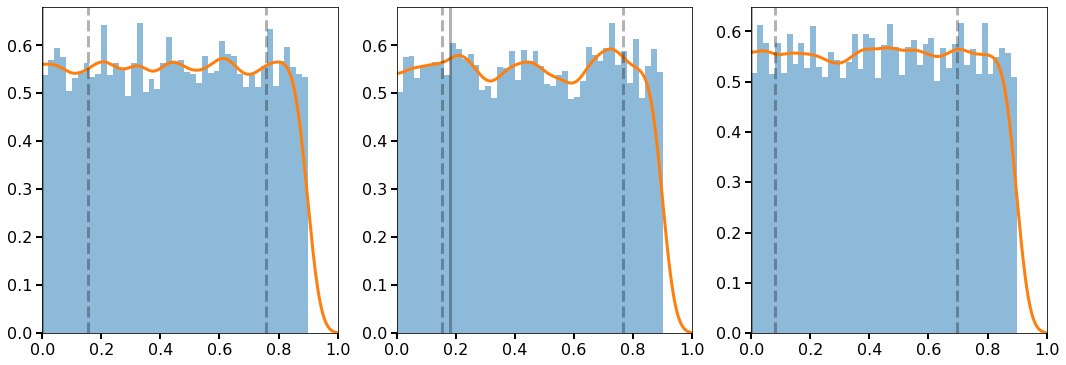

In [133]:
tableline('Stability', dfstab[:10000], ['e1', 'e2', 'e3'], lim=1)

Transit Durations	&	[0, 0.318]	&	[0, 0.408]	&	[0, 0.308]	\\


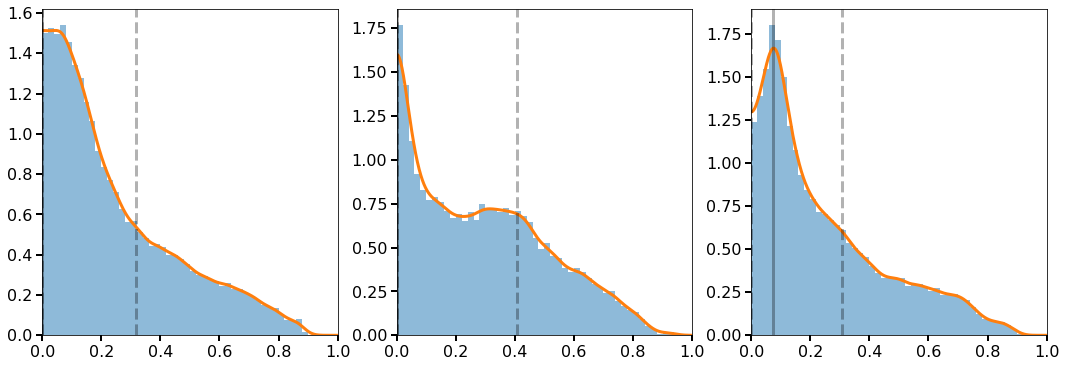

In [150]:
tableline('Transit Durations', dftd, ['e1', 'e2', 'e3'], lim=1)

Stability	&	[0, 0.113]	&	[0, 0.046]	&	[0, 0.070]	\\


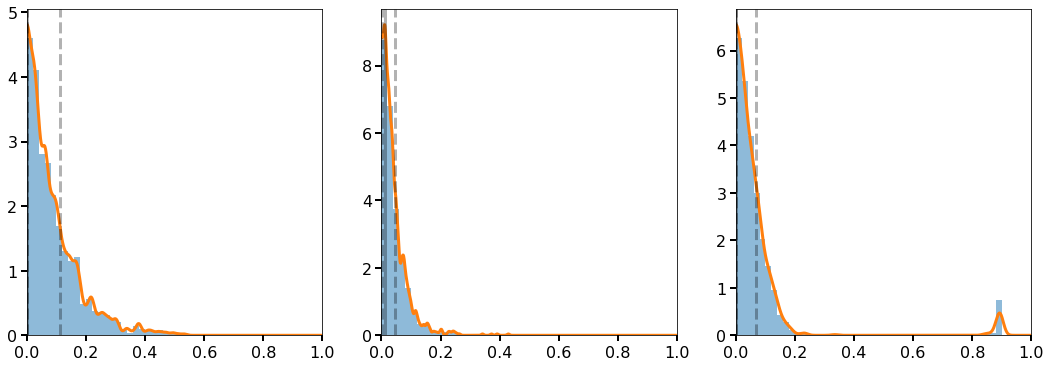

In [15]:
tableline('Stability', dfstab[dfstab['nbodystable']==1], ['e1', 'e2', 'e3'], lim=1)

TTVs	&	[0, 0.074]	&	[0, 0.052]	&	[0, 0.048]	\\


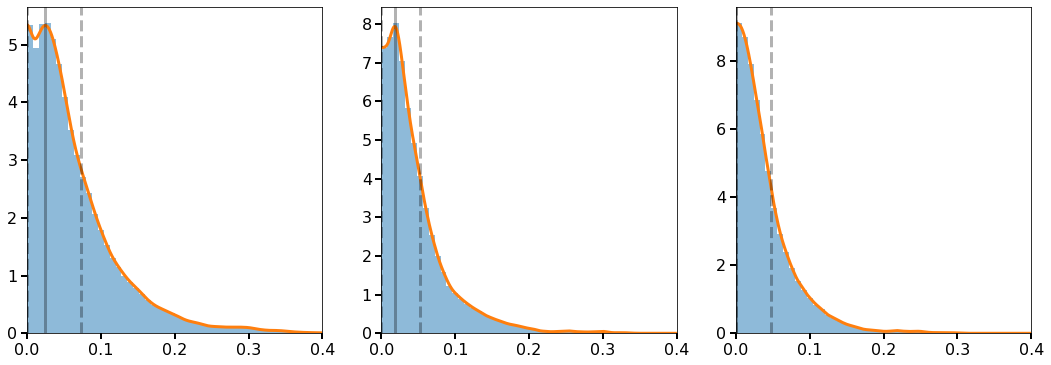

In [174]:
tableline('TTVs', dfttvs, ['e1', 'e2', 'e3'])

Transit Durations	&	[0.046, 0.412]	&	[0.049, 0.397]	&	[0.034, 0.290]	\\


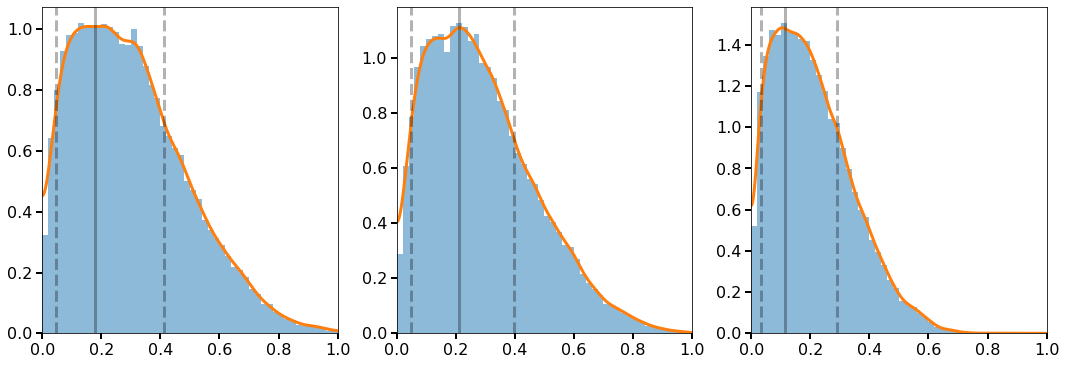

In [126]:
tableline('Transit Durations', dftd, ['Z12', 'Z23', 'ecom'], lim=1)

Stability	&	[0.008, 0.073]	&	[0.002, 0.051]	&	[0, 0.043]	\\


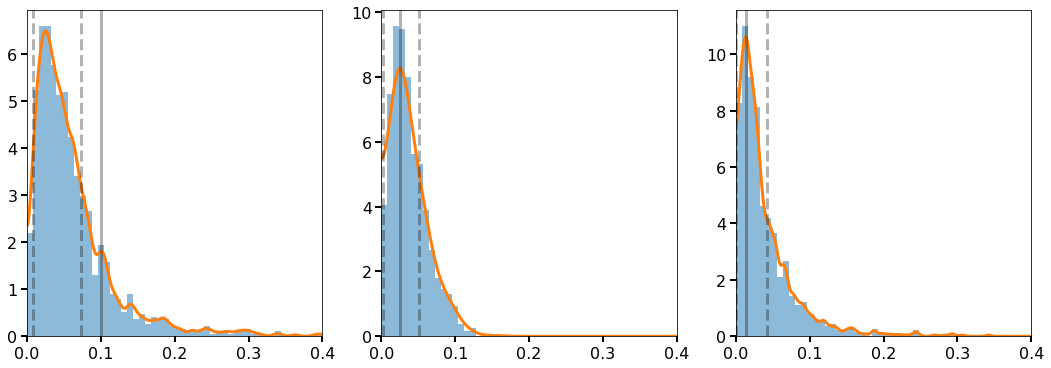

In [10]:
tableline('Stability', dfstab[dfstab['nbodystable']==1], ['Z12', 'Z23', 'ecom'])

Stability	&	[0.007, 0.071]	&	[0.005, 0.050]	&	[0, 0.041]	\\


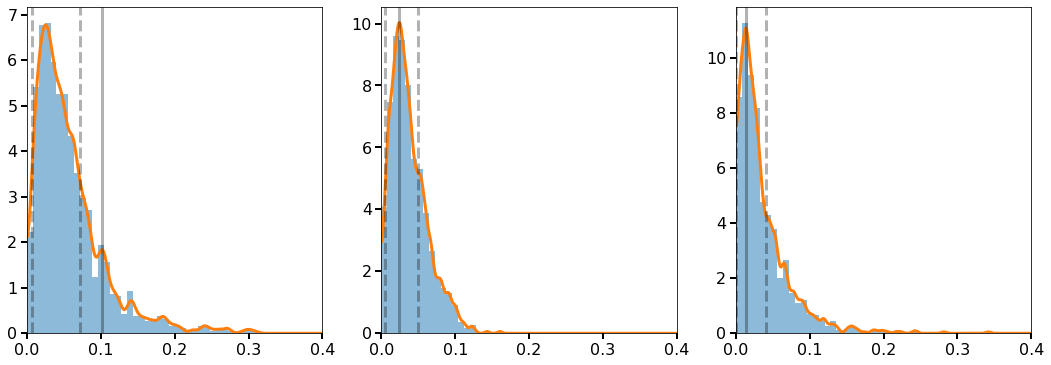

In [16]:
tableline('Stability', dfstab[(dfstab['nbodystable']==1) & (dfstab['e3']<0.8)], ['Z12', 'Z23', 'ecom'])

Stability	&	[0.008, 0.075]	&	[0.003, 0.053]	&	[0, 0.042]	\\


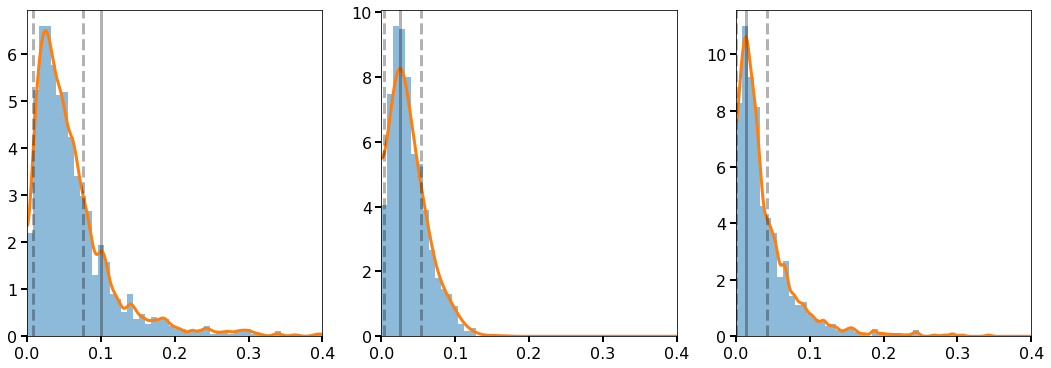

In [20]:
tableline('Stability', dfstab[(dfstab['nbodystable']==1)], ['Z12', 'Z23', 'ecom'])

TTVs	&	[0.012, 0.043]	&	[0.008, 0.035]	&	[0, 0.046]	\\


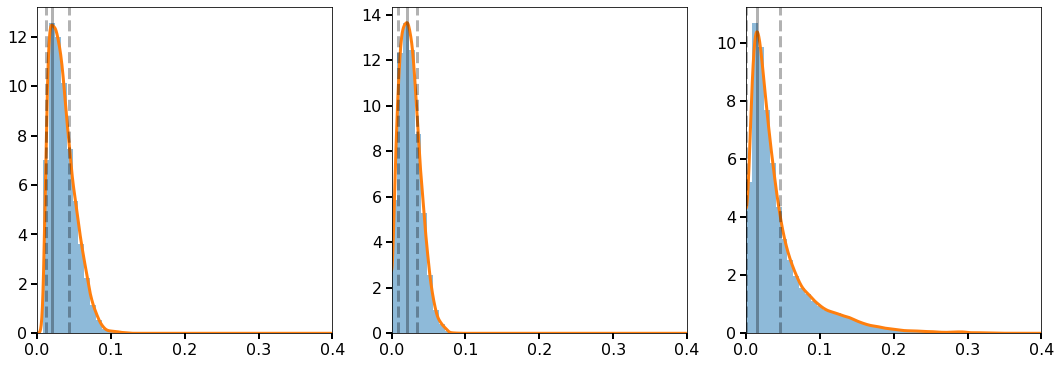

In [128]:
tableline('TTVs', dfttvs, ['Z12', 'Z23', 'ecom'])

Stability	&	[0.178, 0.739]	&	[0.183, 0.743]	&	[0.092, 0.514]	\\


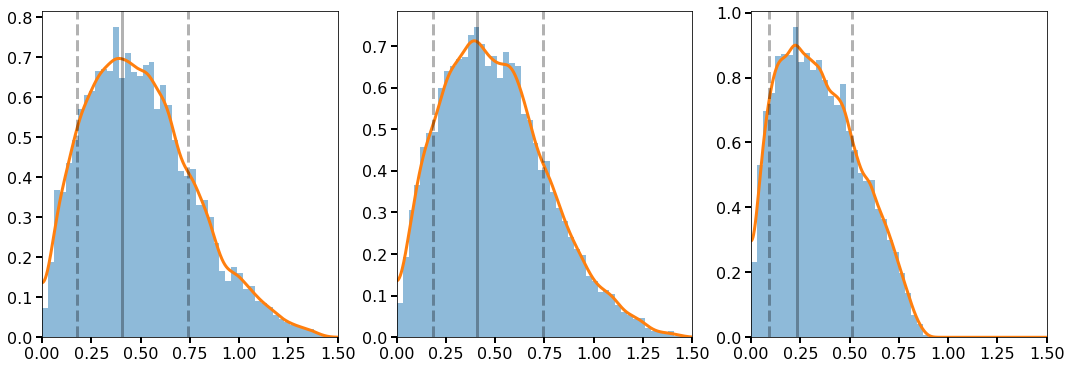

In [132]:
tableline('Stability', dfstab[:10000], ['Z12', 'Z23', 'ecom'], lim=1.5)

# High Z23 values mess up KDE so exclude them

Optimization terminated successfully.
         Current function value: -18.844240
         Iterations: 13
         Function evaluations: 26
68.3% interval=[0.008,0.051]
0.0245 + 0.0264 - 0.0170


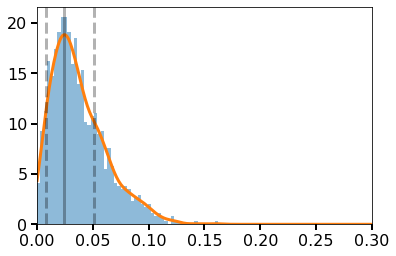

In [91]:
plotposterior(df[(df['nbodystable']==1) & (df['Z23']<0.4)].Z23, 0.683, 0.1, range=[0,0.3])

Optimization terminated successfully.
         Current function value: -18.850297
         Iterations: 13
         Function evaluations: 26
68.3% interval=[0.009,0.051]
0.0227 + 0.0281 - 0.0141


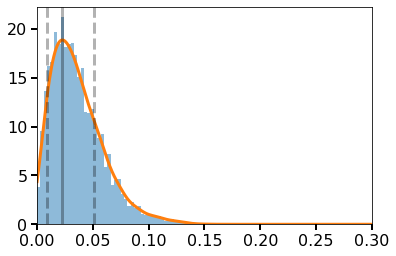

In [83]:
plotposterior(df.Z23, 0.683, 0.1, weights=df.spockprob, range=[0,0.3])

Optimization terminated successfully.
         Current function value: -27.430494
         Iterations: 14
         Function evaluations: 28
68.3% interval=[0.008,0.035]
0.0214 + 0.0135 - 0.0135


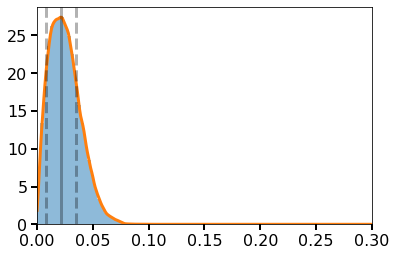

In [84]:
plotposterior(dfhadden.Z23, 0.683, 0.1, range=[0,0.3])